<a href="https://colab.research.google.com/github/nepalprabin/pytorch/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() #interactive mode

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive"

 ADHAR.pdf
 appdata
 Blurred_Images
 Certificates
 Classroom
'Colab Notebooks'
'Computer Vision Model in 10 Minutes.pdf'
 Dataset-01.zip
 faces
 flower_images
'[FreeTutorials.Us] scrapy-tutorial-web-scraping-with-python'
 GRE
'How to get started with Drive.pdf'
 hymenoptera_data
 image-0-02-03-382b8ab95fc17607f75d2cb0033c3d269a337ffe34a95c32012f850a8523204e-V.jpg
 ImageDeblurring.zip
'ImageDeblurring.zip (Unzipped Files)'
 image_p.jpg
 IMG_20190704_183211.jpg
 IMG_20190705_070558.jpg
 kaggle.json
'New Doc 2019-07-04 18.27.19_1.jpg'
'New Doc 2019-07-04 18.27.19_2.jpg'
'New Doc 2019-07-05 07.04.57_1.jpg'
'New Doc 2019-07-05 07.04.57_2.jpg'
 Original_Images
 Prabin_Nepal.pdf
 RESUME.gdoc
 Resume_Prabin.docx
 Resume_Prabin_Nepal.docx
 resume_prabin.pdf
 Resume_Prabin.pdf
 style_image1.jpg
 style_image.jpg
 sujan_resume.pdf
 test.csv
 train.csv
 unknown
 Untitled0.ipynb


In [0]:
# Loading data
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])

    ]),
}

data_dir = '/content/drive/My Drive/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
                    for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

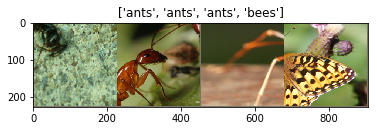

In [30]:
#Visualizing images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std*inp+mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
#Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs-1))
    print('-'*10)

    #Each epoch has a training and validation phase
    for phase in ['train','val']:
      if phase == 'train':
        model.train()   # Set model to training mode
      else:
        model.eval()    # Set model to evaluate mode
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs, labels)

          #backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        #statistics
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc)) 

      #deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
  print('Best val Acc: {:4f}'.format(best_acc))

  #load the best model weights
  model.load_state_dict(best_model_wts)
  return model


In [0]:
# Visualizing model predictions
def visualizing_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs,1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2,2,images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [0]:
# Fine tuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7, gamma=0.1)

In [35]:
#Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4815 Acc: 0.7283
val Loss: 0.2088 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4956 Acc: 0.7717
val Loss: 0.3275 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4727 Acc: 0.8150
val Loss: 0.2038 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3838 Acc: 0.8583
val Loss: 0.4055 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5270 Acc: 0.7913
val Loss: 0.6382 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.5377 Acc: 0.7559
val Loss: 0.4346 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.5666 Acc: 0.7717
val Loss: 0.8968 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.6464 Acc: 0.7756
val Loss: 0.3268 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2777 Acc: 0.8937
val Loss: 0.2634 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2434 Acc: 0.8780
val Loss: 0.2421 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3299 Acc: 0.8740
val Loss: 0.2431 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3041 Acc: 0.8740
val Loss: 0.3714 Acc: 0.8824

Ep

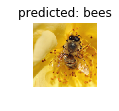

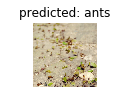

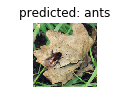

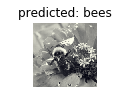

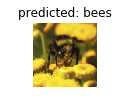

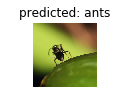

In [36]:
visualizing_model(model_ft)

In [0]:
#ConvNet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_fltrs  = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_fltrs,2)

model_conv = model_conv.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
#Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6556 Acc: 0.6496
val Loss: 0.2281 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5869 Acc: 0.7559
val Loss: 0.3042 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5324 Acc: 0.7480
val Loss: 0.3135 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3860 Acc: 0.8504
val Loss: 0.2326 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4505 Acc: 0.8031
val Loss: 0.2423 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4794 Acc: 0.8031
val Loss: 0.4212 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.3730 Acc: 0.8150
val Loss: 0.2256 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3910 Acc: 0.8268
val Loss: 0.2519 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3754 Acc: 0.8307
val Loss: 0.2473 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4913 Acc: 0.7638
val Loss: 0.2262 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4108 Acc: 0.8228
val Loss: 0.2477 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3215 Acc: 0.8425
val Loss: 0.2120 Acc: 0.9412

Ep

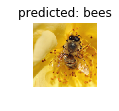

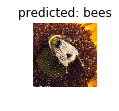

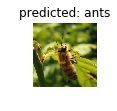

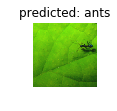

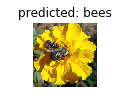

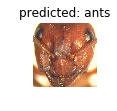

In [44]:
visualizing_model(model_conv)

plt.ioff()
plt.show()